## Neuroevolution using EvoTorch

#### Imports

In [1]:
import torch
import numpy as np
import math

from evotorch.tools import dtype_of, device_of
from evotorch.neuroevolution import NEProblem
from evotorch.algorithms import PGPE
from evotorch.logging import PandasLogger, StdOutLogger

from Trainer import Trainer
from Model import Complex_CA
from State_Generator import Generator, State

In [2]:
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cpu')
batch_size = 16
#model = Complex_CA(device, batch_size)
#model = model.to(device)
generator = Generator(False)

#### Helper functions

In [3]:
batch = generator.generate_ca_and_food(batch_size)

In [4]:
def average_placement(x):
    size = x.shape[0]
    d1 = 0
    d2 = 0
    total = x.sum() / size
    if total == 0:
        return(100, 100)
    
    def to_int(x):
        if math.isnan(x):
            return 0
        else:
            return int(x)

    for i in range(size):
        d1 += x[i].mean() * i / total
        d2 += x[:, i].mean() * i / total
    return (to_int(d1), to_int(d2))

#### Network

#### Fitness function

In [5]:
#test
batch = generator.generate_ca_and_food(batch_size)
batch = torch.tensor(batch, device=device)
cell = batch
food = batch[:, 3]
#food_pos = np.apply_along_axis(average_placement, 1, food)
food_pos = np.ones(shape=(17,2))
average_cell_pos = np.ones(shape=(17,2))
for i, x in enumerate(food):
    food_pos[i] = average_placement(x)
for i, x in enumerate(cell[:, 0]):
    average_cell_pos[i] = average_placement(x)
distance = ((food_pos - average_cell_pos) ** 2).sum()/100
print(distance)

1.94


In [6]:
def score(network: torch.nn.Module):
    #return torch.tensor([0.2], dtype=dtype_of(network), device=device_of(network))
    batch = generator.generate_ca_and_food(batch_size)
    batch = torch.tensor(batch, dtype=dtype_of(network), device=device_of(network))
    cell = batch
    food = batch[:, 3]


    total_pixel_val_before = network.total_pixel_val(cell[:, 0:1])    
    living_count_before = network.living_cells_above(cell[:, 0:1], 0.1)
    #TODO compute the distance to the food
    #food_pos = [average_placement(i) for i in food]
    #food_pos = np.apply_along_axis(average_placement, 0, food)
    food_pos = np.ones(shape=(17,2))
    for i, x in enumerate(food):
        food_pos[i] = average_placement(x)

    steps = 15

    cell, food, total_pixel_val, living_count = network(cell, food, steps)
    
    total_pixel_diff = ((total_pixel_val_before - total_pixel_val) ** 2).sum()
    living_count_diff = ((living_count_before - living_count) ** 2).sum()
    #average_cell_pos = [average_placement(i) for i in cell[:, 0]]
    #average_cell_pos = np.apply_along_axis(average_placement, 0, cell[:, 0])
    average_cell_pos = np.ones(shape=(17,2))
    for i, x in enumerate(cell[:, 0]):
        average_cell_pos[i] = average_placement(x)
    distance = ((food_pos-average_cell_pos) ** 2).sum()

    #TODO add sum of distances to the food to the fitness function
    fitness = total_pixel_diff/3 + living_count_diff/100 + distance/20
    return fitness


    #TODO initial state of CA
    #TODO initial food state - apply food scent spread

    #iterate through x number of time_steps

    #evaluate the models behavior ...

#### Creating problem

In [7]:
problem = NEProblem(
    objective_sense="min",
    network=Complex_CA,
    network_args={"device":device, "batch_size":batch_size},
    network_eval_func=score,
    device="cpu",
    num_actors=10,
)

#### Searcher algorithm

In [8]:
searcher = PGPE(
    problem,
    popsize=1000,
    radius_init=2.25,
    center_learning_rate=0.0005,
    stdev_learning_rate=0.0002,
)

#### Logger and run

In [9]:
logger = StdOutLogger(searcher)
logger = PandasLogger(searcher)
searcher.run(100)

2022-11-29 14:43:46,482	INFO worker.py:1528 -- Started a local Ray instance.


         iter : 1
    mean_eval : 155512.640625
pop_best_eval : 9.650690078735352
  median_eval : 2496.88330078125
    best_eval : 9.650690078735352
   worst_eval : 4399602.5

         iter : 2
    mean_eval : 158015.859375
pop_best_eval : 13.260217666625977
  median_eval : 2688.274169921875
    best_eval : 9.650690078735352
   worst_eval : 4399602.5

         iter : 3
    mean_eval : 138065.640625
pop_best_eval : 24.611255645751953
  median_eval : 2331.88037109375
    best_eval : 9.650690078735352
   worst_eval : 4399602.5

         iter : 4
    mean_eval : 160885.203125
pop_best_eval : 23.789026260375977
  median_eval : 2339.89697265625
    best_eval : 9.650690078735352
   worst_eval : 4523360.5

         iter : 5
    mean_eval : 148777.9375
pop_best_eval : 33.98813247680664
  median_eval : 2436.62255859375
    best_eval : 9.650690078735352
   worst_eval : 4523360.5

         iter : 6
    mean_eval : 157501.5
pop_best_eval : 26.067216873168945
  median_eval : 2148.861328125
    best_

#### Show learning curve

<AxesSubplot:xlabel='iter'>

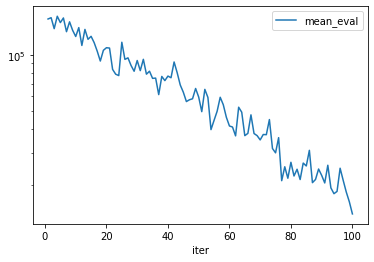

In [17]:
#TODO find a way of showing this in logarithmic scale
#logger.to_dataframe().mean_eval.plot(Log=True)
#logger.to_dataframe().mean_eval.plot()
#x = logger.to_dataframe().mean_eval
#logger.to_dataframe().mean_eval.plot(log=True)
logger.to_dataframe().plot(y='mean_eval', logy=True)

<AxesSubplot:xlabel='iter'>

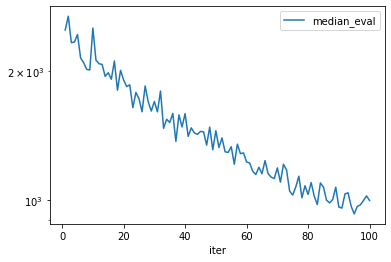

In [18]:
logger.to_dataframe().plot(y='median_eval', logy=True)

#### Get Network with parameters according to trained model

In [12]:
trained_network = problem.parameterize_net(searcher.status['center'])
#save model
torch.save(trained_network.state_dict(), 'models/evo2.pth')

#### Use Model

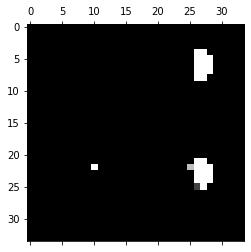

In [13]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import IPython

#TODO
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    row2 = np.hstack((state.food[0], state.y[0]))
    return np.vstack((row1, row2))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()

mat = ax.matshow(extract_data(cell, target), cmap='gray')

video = IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=150, interval=50).to_jshtml())
video

In [14]:
state = generator.generate_moving_state(50, batch_size)
cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)

In [15]:
#animate
def animate2(i, cell, target, food):
    global food_coord
    cell, food, live_count, _ = trained_network(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 
    i += 1
    return cell, target, i
i = 0

tensor(165.5349, grad_fn=<SumBackward0>)


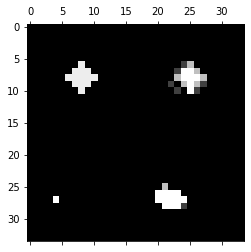

In [16]:
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')
cell, target, i = animate2(i, cell, target, food)
print(cell[:, 0].sum())